In [ ]:
pip install tensorflow-ranking

In [10]:
import torchvision
import tensorflow as tf
from google.colab import drive
import pandas as pd
import os
import cv2
import json
import numpy as np
import base64
from pathlib import Path
import torch
from torchvision import transforms
from PIL import Image
import tensorflow_ranking as tfr


drive.mount('/content/Mydrive')

Drive already mounted at /content/Mydrive; to attempt to forcibly remount, call drive.mount("/content/Mydrive", force_remount=True).


In [3]:
def load_image(image_path):
    image = Image.open(image_path)
    return np.array(image)


In [4]:
input_image_dir = "/content/Mydrive/MyDrive/leishmania/"
input_json_dir = "/content/Mydrive/MyDrive/Labels-json/"
labels = []
images = []

for i in range(1,144):
  file_path = input_json_dir+f"{i}.json"
  jpg_IMAGE_PATH =input_image_dir+f"{i}.jpg"
  jpeg_IMAGE_PATH = input_image_dir +f"{i}.JPG"

  if os.path.exists(jpg_IMAGE_PATH):
    IMAGE_PATH = jpg_IMAGE_PATH
  elif os.path.exists(jpeg_IMAGE_PATH):
    IMAGE_PATH = jpeg_IMAGE_PATH
  try:
    with open(file_path, 'r') as file:
      data = json.load(file)
      image =load_image(IMAGE_PATH)
      images.append(image)
      boxes = []
      for shape in data["shapes"]:

          boxes.append({
              "x": shape["points"][0][0],
              "y": shape["points"][0][1],
              "width" :  shape["points"][1][0],
              "height" :  shape["points"][1][1],
              "label": shape["label"]
          })

      boxes = np.array([
          [
              box['x'],
              box['y'],
              box['width'],
              box['height']
          ] for box in boxes
        ])
      labels.append(boxes)
  except :
    print(f"{i}" +" error while reading")

In [5]:
def resize_image_and_boxes(image, boxes, target_size):
    orig_h, orig_w = image.shape[:2]

    if(orig_h > target_size[1] | orig_w > target_size(1)):
        ratio = min(target_size[0] / orig_w, target_size[1] / orig_h)
        new_size = (int(orig_w * ratio), int(orig_h * ratio))

        image_pil = Image.fromarray(image)
        resized_image = np.array(image_pil.resize(new_size, Image.LANCZOS))

        resized_boxes = boxes * np.array([ratio, ratio, ratio, ratio])
    else:
        resized_image = image
        resized_boxes = boxes

    return resized_image, resized_boxes

target_size = (1200, 1200)


def process_batch(image_paths, all_boxes, target_size):
    resized_images = []
    resized_all_boxes = []

    for image, boxes in zip(image_paths, all_boxes):
        resized_image, resized_boxes = resize_image_and_boxes(image, boxes, target_size)

        resized_images.append(resized_image)
        resized_all_boxes.append(resized_boxes)

    return resized_images, resized_all_boxes


resized_images, resized_all_boxes = process_batch(images, labels, target_size)


In [6]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(pretrained = True)
model.eval()


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, images, boxes):
        self.images = images
        self.boxes = [self.validate_boxes(box) for box in boxes]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx], dtype=torch.float32).permute(2, 0, 1) / 255.0
        boxes = self.boxes[idx]

        boxes_tensor = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.ones((boxes_tensor.shape[0],), dtype=torch.int64)

        target = {
            'boxes': boxes_tensor,
            'labels': labels,
            'image_id': torch.tensor([idx])
        }

        return image, target

    def validate_boxes(self, boxes):
        valid_boxes = []
        for box in boxes:
            xmin, ymin, xmax, ymax = box

            xmin, xmax = min(xmin, xmax), max(xmin, xmax)
            ymin, ymax = min(ymin, ymax), max(ymin, ymax)

            if xmax > xmin and ymax > ymin:
                valid_boxes.append([xmin, ymin, xmax, ymax])
        return valid_boxes

def collate_fn(batch):
    return tuple(zip(*batch))

def train_model(model, data_loader, optimizer, num_epochs=10):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            total_loss += losses.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(data_loader):.4f}")

In [15]:
def evaluate_model(model, data_loader):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    model.eval()

    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for output, target in zip(outputs, targets):
                pred_boxes = output['boxes']
                pred_labels = output['labels']
                true_boxes = target['boxes']
                true_labels = target['labels']

                iou_threshold = 0.5
                for pred_box, pred_label in zip(pred_boxes, pred_labels):
                    ious = torchvision.ops.box_iou(pred_box.unsqueeze(0), true_boxes)
                    max_iou, max_idx = torch.max(ious, dim=1)
                    if max_iou > iou_threshold and pred_label == true_labels[max_idx]:
                        total_correct += 1

                total_samples += len(true_boxes)

    accuracy = total_correct / total_samples
    print(f"Evaluation Accuracy: {accuracy:.4f}")
    return accuracy

In [19]:
def evaluate_model(model, test_loader, device, metric, max_detections=200, score_threshold=0.5):
    model.to(device)
    model.eval()

    y_true = []
    y_pred_scores = []

    with torch.no_grad():
        for images, targets in test_loader:
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)

            for target, output in zip(targets, outputs):
                true_labels = target['labels'].cpu().numpy()
                pred_scores = output['scores'].cpu().numpy()
                pred_labels = output['labels'].cpu().numpy()

                keep = pred_scores >= score_threshold
                pred_scores = pred_scores[keep]
                pred_labels = pred_labels[keep]

                true_labels = (true_labels == 1).astype(np.float32)
                pred_scores = (pred_labels == 1).astype(np.float32) * pred_scores

                true_labels_padded = np.pad(true_labels, (0, max_detections - len(true_labels)), 'constant', constant_values=0)[:max_detections]
                pred_scores_padded = np.pad(pred_scores, (0, max_detections - len(pred_scores)), 'constant', constant_values=0)[:max_detections]

                y_true.append(true_labels_padded)
                y_pred_scores.append(pred_scores_padded)

    y_true = np.stack(y_true, axis=0)
    y_pred_scores = np.stack(y_pred_scores, axis=0)

    metric.update_state(tf.convert_to_tensor(y_true), tf.convert_to_tensor(y_pred_scores))
    map_score = metric.result().numpy()

    metric.reset_states()

    return map_score

In [38]:

def main(resized_images, resized_all_boxes):

    dataset = CustomDataset(resized_images, resized_all_boxes)
    data_loader = DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

    num_classes = 2

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

    train_model(model, data_loader, optimizer, num_epochs=10)

    map_metric = tfr.keras.metrics.MeanAveragePrecisionMetric(name="mAP", topn=100)
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    map_score = evaluate_model(model, data_loader, device, map_metric)

    print(f"mAP Score: {map_score:.4f}")

    return model

trained_model = main(resized_images, resized_all_boxes)

Epoch 1/10, Loss: 0.7090
Epoch 2/10, Loss: 0.6090
Epoch 3/10, Loss: 0.5834
Epoch 4/10, Loss: 0.5781
Epoch 5/10, Loss: 0.5686
Epoch 6/10, Loss: 0.5603
Epoch 7/10, Loss: 0.5691
Epoch 8/10, Loss: 0.5453
Epoch 9/10, Loss: 0.5391
Epoch 10/10, Loss: 0.5364
mAP Score: 0.8928


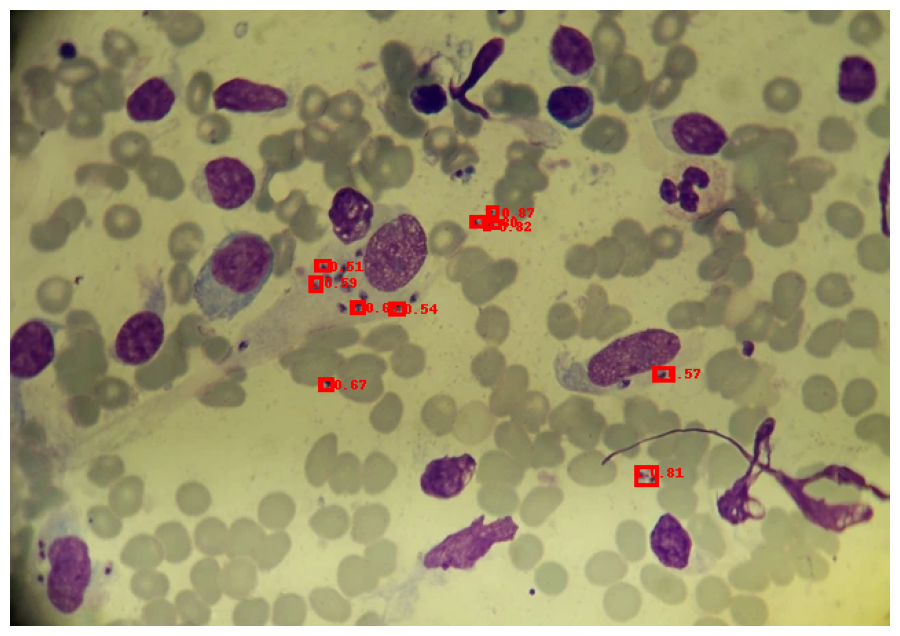

In [39]:
import torch
import torchvision.transforms as T
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    transform = T.ToTensor()
    return transform(image).unsqueeze(0), image

def make_prediction(model, image_tensor):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        prediction = model(image_tensor)

    return prediction


def visualize_predictions(image, predictions, threshold=0.5):
    draw = ImageDraw.Draw(image)

    for element in predictions:
        boxes = element['boxes']
        labels = element['labels']
        scores = element['scores']

        for box, label, score in zip(boxes, labels, scores):
            if score >= threshold:
                xmin, ymin, xmax, ymax = box
                draw.rectangle(((xmin, ymin), (xmax, ymax)), outline="red", width=3)
                draw.text((xmin, ymin), f"{label.item()} {score:.2f}", fill="red")

    plt.figure(figsize=(12, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def main(image_path):

    image_tensor, original_image = preprocess_image(image_path)

    predictions = make_prediction(trained_model, image_tensor)

    visualize_predictions(original_image, predictions, threshold=0.5)

image_path ='/content/leıshmanıa.jpg'

main(image_path)